# Copyright Netherlands eScience Center <br>
** Function     : Link between AMET and surface flux & the change of ocean heat content** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.12.11 ** <br>
** Last Update  : 2018.12.11** <br>
Description     : The script aims to investigate the link between the atmospheric energy transport and    the net surface flux. Relation between AMET and ocean heat content is also checked here. This study can help us understand how the AMET will affect the Arctic. Existing theory gives that AMET can increase SFlux, which will hide in the water (OHC) and will be released in water to melt sea ice.<br>
For SFlux and OHC, we are only interested in the integral in the polar circle.<br>
The AMET and SFlux are calculated from atmospheric reanalysis. In this case, it includes ERA-Interim, MERRA2, and JRA55. The OHC are calculated from reanalysis datasets. In this case, it includes GLORYS2V3 from Mercator Ocean, ORAS4 from ECMWF, and SODA3 from University of Maryland & TAMU.<br>
Return Values   : netCDF4, png <br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib <br>
variables       : Atmospheric Meridional Energy Transport <br>
Net Surface Flux <br>
Ocean Heat Content <br>
Caveat          : <br>

In [45]:
import numpy as np
import seaborn as sns
#import scipy as sp
import time as tttt
from netCDF4 import Dataset,num2date
import os
import platform
import sys
import logging
import matplotlib
# generate images without having a window appear
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#from scipy.interpolate import InterpolatedUnivariateSpline
import scipy
from scipy import stats
#from mpl_toolkits.basemap import Basemap, cm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import iris
import iris.plot as iplt
import iris.quickplot as qplt
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import meta.statistics
import meta.visualizer

In [ ]:
# switch on the seaborn effect
sns.set()
#sns.set_style("whitegrid")
#sns.set_style("darkgrid")
sns.set_style("ticks")
sns.despine()

In [ ]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'HoF' : 334,        # heat of fusion of ice [KJ/Kg]
            'rho_ice' : 0.91    # density of sea ice [g/cm3]
            }

In [ ]:
################################   Input zone  ######################################
print ('****************************************************************************')
print ('*****************************   data path   ********************************')
print ('****************************************************************************')
# specify data path
# AMET
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
datapath_MERRA2 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/postprocessing'
datapath_JRA55 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/postprocessing'
# net SFlux
datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
datapath_MERRA2_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/regression'
datapath_JRA55_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/regression'
# OHC
# target fields for regression
datapath_OHC_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4/statistics'
datapath_OHC_GLORYS2V3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3/statistics'
datapath_OHC_SODA3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3/statistics'
datapath_OHC_NEMO = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORCA012_BenMoat/postprocessing'
# mask path
datapath_mask_ORAS4 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
datapath_mask_GLORYS2V3 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3'
datapath_mask_SODA3 ='/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3'
# specify output path for figures
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/figures/revision'
################################   Input zone  ######################################

In [ ]:
################################   Input zone  ######################################
print ('****************************************************************************')
print ('********************    latitude index of insteret     *********************')
print ('****************************************************************************')
# 60N
lat_ERAI_60 = 40
lat_MERRA2_60 = 80
lat_JRA55_60 = 53

lat_ORAS4_60 = 233
lat_GLORYS2V3_60 = 788
lat_SODA3_60 = 789
lat_NEMO_60 = 871
# after a cut to 20-90 N
lat_ORAS4_60_cut = 53
lat_GLORYS2V3_60_cut = 209
lat_SODA3_60_cut = 220
lat_NEMO_60_cut = 626

# 70N
lat_ORAS4_70 = 250
lat_GLORYS2V3_70 = 857
lat_SODA3_70 = 880
lat_NEMO_70 = 1078
# after a cut to 20-90 N
lat_ORAS4_70_cut = 70
lat_GLORYS2V3_70_cut = 278
lat_SODA3_70_cut = 311

In [ ]:
print ('*******************************************************************')
print ('*********************** extract variables *************************')
print ('*******************************************************************')
# AMET
dataset_ERAI_AMET = Dataset(os.path.join(datapath_ERAI, 'model_daily_075_1979_2016_E_zonal_int.nc'))
dataset_MERRA2_AMET = Dataset(os.path.join(datapath_MERRA2, 'AMET_MERRA2_model_daily_1980_2016_E_zonal_int.nc'))
dataset_JRA55_AMET = Dataset(os.path.join(datapath_JRA55, 'AMET_JRA55_model_daily_1979_2015_E_zonal_int.nc'))
# net SFlux
dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields, 'surface_erai_monthly_regress_1979_2017_radiation.nc'))
dataset_MERRA2_fields_flux = Dataset(os.path.join(datapath_MERRA2_fields, 'surface_merra_monthly_regress_1980_2017_SFlux_Rad.nc'))
dataset_JRA55_fields_flux = Dataset(os.path.join(datapath_JRA55_fields, 'surface_JRA55_monthly_model_regress_SFlux_Rad_1979_2013.nc'))
# OHC
dataset_OHC_GLORYS2V3 = Dataset(os.path.join(datapath_OHC_GLORYS2V3, 'GLORYS2V3_model_monthly_orca025_OHC_point.nc'))
dataset_OHC_ORAS4 = Dataset(os.path.join(datapath_OHC_ORAS4, 'oras4_model_monthly_orca1_OHC_point.nc'))
dataset_OHC_SODA3 = Dataset(os.path.join(datapath_OHC_SODA3, 'OMET_SODA3_model_5daily_1980_2015_OHC.nc'))
dataset_OHC_NEMO = Dataset(os.path.join(datapath_OHC_NEMO, 'OHC_NEMO_ORCA0083_daily_1979_2012_zonal_int.nc'))
print ('****************** extract the AMET fields ********************')
# from 20N - 90N
# ! attention MERRA2 goes from lower lat to higher lat
AMET_ERAI = dataset_ERAI_AMET.variables['E'][:,:,lat_ERAI_60]/1000 # from Tera Watt to Peta Watt
AMET_MERRA2 = dataset_MERRA2_AMET.variables['E'][:,:,lat_MERRA2_60]/1000 # from Tera Watt to Peta Watt
AMET_JRA55 = dataset_JRA55_AMET.variables['E'][:,:,lat_JRA55_60]/1000 # from Tera Watt to Peta Watt

year_ERAI = dataset_ERAI_AMET.variables['year'][:]             # from 1979 to 2016
year_MERRA2 = dataset_MERRA2_AMET.variables['year'][:]         # from 1980 to 2016
year_JRA55 = dataset_JRA55_AMET.variables['year'][:]           # from 1979 to 2015

latitude_ERAI = dataset_ERAI_AMET.variables['latitude'][:lat_ERAI_60+1]
latitude_MERRA2 = dataset_MERRA2_AMET.variables['latitude'][lat_MERRA2_60:]
latitude_JRA55 = dataset_JRA55_AMET.variables['latitude'][:lat_JRA55_60+1]

In [36]:
print ('****************** extract the OHC fields ********************')
# we are only interested in the polar circle
# mask
#mask_ORAS4 = dataset_mask_ORAS4.variables['vmask'][0,0,:,:]
#mask_GLORYS2V3 = dataset_mask_GLORYS2V3.variables['vmask'][0,0,:,:]
#mask_SODA3 = dataset_mask_SODA3.variables['wet_c'][:]
# extract variables with netcdf tool and take zonal mean
# change unit from tera joule to 1E+22 joule
OHC_glo_vert_ORAS4 = np.sum(dataset_OHC_ORAS4.variables['OHC_glo_vert'][21:,:,lat_ORAS4_60:,:],3)/1E+10      # start from 1979
OHC_glo_vert_GLORYS2V3 = np.sum(dataset_OHC_GLORYS2V3.variables['OHC_glo_vert'][:,:,lat_GLORYS2V3_60:,:],3)/1E+10# start from 1993
OHC_glo_vert_SODA3 = np.sum(dataset_OHC_SODA3.variables['OHC_glo_vert'][:,:,lat_SODA3_60:,:],3)/1E+10        # start from 1980
OHC_glo_vert_NEMO = dataset_OHC_NEMO.variables['OHC_glo_zonal_int'][:,:,lat_NEMO_60:] /1E+10
# year
year_ORAS4 = dataset_OHC_ORAS4.variables['year'][21:]         # from 1979 to 2014
year_GLORYS2V3 = dataset_OHC_GLORYS2V3.variables['year'][:]   # from 1993 to 2014
year_SODA3 = dataset_OHC_SODA3.variables['year'][:]           # from 1980 to 2015
year_NEMO = dataset_OHC_NEMO.variables['year'][:]           # from 1979 to 2012
# nominal latitude
latitude_ORAS4 = dataset_OHC_ORAS4.variables['latitude_aux'][180:]
latitude_GLORYS2V3 = dataset_OHC_GLORYS2V3.variables['latitude_aux'][579:]
latitude_SODA3 = dataset_OHC_SODA3.variables['latitude_aux'][569:]
latitude_NEMO = dataset_OHC_NEMO.variables['latitude_aux'][:]
# take the integral inside the polar circle
OHC_glo_vert_ORAS4_int = np.sum(OHC_glo_vert_ORAS4,2)
OHC_glo_vert_GLORYS2V3_int = np.sum(OHC_glo_vert_GLORYS2V3,2)
OHC_glo_vert_SODA3_int = np.sum(OHC_glo_vert_SODA3,2)
OHC_glo_vert_NEMO_int = np.sum(OHC_glo_vert_NEMO,2)

In [ ]:
print (OHC_glo_vert_ORAS4_int)

In [ ]:
#####################################################################################
print ('****************** extract the net flux fields ********************')
print ('*******************************************************************')
# we are only interested in the polar circle
latitude_fields_ERAI = dataset_ERAI_fields_flux.variables['latitude'][:]
longitude_fields_ERAI = dataset_ERAI_fields_flux.variables['longitude'][:]
latitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['latitude'][:]
longitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['longitude'][:]
latitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['latitude'][:]
longitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['longitude'][:]
print ('*********************** post-process era fields *************************')
rad_short_toa_ERAI = np.sum(dataset_ERAI_fields_flux.variables['tsr'][:-1,:,:lat_ERAI_60+1,:],3)
rad_long_toa_ERAI = np.sum(dataset_ERAI_fields_flux.variables['ttr'][:-1,:,:lat_ERAI_60+1,:],3)
rad_short_surf_ERAI = np.sum(dataset_ERAI_fields_flux.variables['ssr'][:-1,:,:lat_ERAI_60+1,:],3)
rad_long_surf_ERAI = np.sum(dataset_ERAI_fields_flux.variables['str'][:-1,:,:lat_ERAI_60+1,:],3)
SFlux_sensible_ERAI = np.sum(dataset_ERAI_fields_flux.variables['sshf'][:-1,:,:lat_ERAI_60+1,:],3)
SFlux_latent_ERAI = np.sum(dataset_ERAI_fields_flux.variables['slhf'][:-1,:,:lat_ERAI_60+1,:],3)
# calculate total net energy flux at TOA/surface
net_flux_surf_ERAI = rad_short_surf_ERAI[:] + rad_long_surf_ERAI[:] +\
                     SFlux_sensible_ERAI[:] + SFlux_latent_ERAI[:]
net_flux_toa_ERAI = rad_short_toa_ERAI[:] + rad_long_toa_ERAI[:]
# save memory
del rad_short_toa_ERAI, rad_long_toa_ERAI, rad_short_surf_ERAI, rad_long_surf_ERAI
del SFlux_sensible_ERAI, SFlux_latent_ERAI
print ('*********************** post-process merra fields *************************')
rad_short_toa_MERRA2 = np.sum(dataset_MERRA2_fields_flux.variables['SWTNT'][:-1,:,-61:,:],3)
rad_long_toa_MERRA2 = np.sum(dataset_MERRA2_fields_flux.variables['LWTUP'][:-1,:,-61:,:],3)
rad_short_surf_MERRA2 = np.sum(dataset_MERRA2_fields_flux.variables['SWGNT'][:-1,:,-61:,:],3)
rad_long_surf_MERRA2 = np.sum(dataset_MERRA2_fields_flux.variables['LWGNT'][:-1,:,-61:,:],3)
SFlux_sensible_MERRA2 = np.sum(dataset_MERRA2_fields_flux.variables['HFLUX'][:-1,:,-61:,:],3)
SFlux_latent_MERRA2 = np.sum(dataset_MERRA2_fields_flux.variables['EFLUX'][:-1,:,-61:,:],3)
# calculate total net energy flux at TOA/surface
# merra - watch out! the sign
# reverse the meridional coordinate of MERRA2 for the sake of the calc. of residual
net_flux_surf_MERRA2 = rad_short_surf_MERRA2[:,:,:] + rad_long_surf_MERRA2[:,:,:] -\
                       SFlux_sensible_MERRA2[:,:,:] - SFlux_latent_MERRA2[:,:,:]
net_flux_toa_MERRA2 = rad_short_toa_MERRA2[:,:,:] - rad_long_toa_MERRA2[:,:,:]
del rad_short_toa_MERRA2, rad_long_toa_MERRA2, rad_short_surf_MERRA2, rad_long_surf_MERRA2
del SFlux_sensible_MERRA2, SFlux_latent_MERRA2
print ('*********************** post-process jra fields *************************')
rad_net_toa_JRA55 = np.sum(dataset_JRA55_fields_flux.variables['nRadT'][:,:,:lat_JRA55_60+1,:],3)
rad_net_surf_JRA55 = np.sum(dataset_JRA55_fields_flux.variables['nRadS'][:,:,:lat_JRA55_60+1,:],3)
SFlux_sensible_JRA55 = np.sum(dataset_JRA55_fields_flux.variables['SFlux'][:,:,:lat_JRA55_60+1,:],3)
SFlux_latent_JRA55 = np.sum(dataset_JRA55_fields_flux.variables['LFlux'][:,:,:lat_JRA55_60+1,:],3)
# calculate total net energy flux at TOA/surface
net_flux_surf_JRA55 = rad_net_surf_JRA55[:] + SFlux_sensible_JRA55[:] +\
                      SFlux_latent_JRA55[:]
net_flux_toa_JRA55 = rad_net_toa_JRA55[:]
del rad_net_surf_JRA55, SFlux_sensible_JRA55, SFlux_latent_JRA55
print ('*********************** convert W/m2 to PW *************************')
# area weighted surface flux
# era
net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float)
net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
# merra
net_flux_surf_MERRA2_area = np.zeros(net_flux_surf_MERRA2.shape, dtype=float)
net_flux_toa_MERRA2_area = np.zeros(net_flux_toa_MERRA2.shape, dtype=float)
# jra
net_flux_surf_JRA55_area = np.zeros(net_flux_surf_JRA55.shape, dtype=float)
net_flux_toa_JRA55_area = np.zeros(net_flux_toa_JRA55.shape, dtype=float)
#size of the grid box
# era
dx_ERAI = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI /
          360) / len(longitude_fields_ERAI)
dy_ERAI = np.pi * constant['R'] / len(latitude_fields_ERAI)
# merra
dx_MERRA2 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_MERRA2 /
            360) / len(longitude_fields_MERRA2)
dy_MERRA2 = np.pi * constant['R'] / len(latitude_fields_MERRA2)
# jra
dx_JRA55 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_JRA55 /
           360) / len(longitude_fields_JRA55)
dy_JRA55 = np.pi * constant['R'] / len(latitude_fields_JRA55)
# era
for i in np.arange(len(latitude_ERAI)):
    # change the unit to terawatt
    net_flux_surf_ERAI_area[:,:,i] = net_flux_surf_ERAI[:,:,i] * dx_ERAI[i] *\
                                     dy_ERAI / 1E+15
    net_flux_toa_ERAI_area[:,:,i] = net_flux_toa_ERAI[:,:,i] * dx_ERAI[i] *\
                                    dy_ERAI / 1E+15
# merra
for i in np.arange(len(latitude_MERRA2)):
    # change the unit to terawatt
    net_flux_surf_MERRA2_area[:,:,i] = net_flux_surf_MERRA2[:,:,i] * dx_MERRA2[i] *\
                                       dy_MERRA2 / 1E+15
    net_flux_toa_MERRA2_area[:,:,i] = net_flux_toa_MERRA2[:,:,i] * dx_MERRA2[i] *\
                                      dy_MERRA2 / 1E+15
# jra
for i in np.arange(len(latitude_JRA55)):
    # change the unit to terawatt
    net_flux_surf_JRA55_area[:,:,i] = net_flux_surf_JRA55[:,:,i] * dx_JRA55[i] *\
                                      dy_JRA55 / 1E+15
    net_flux_toa_JRA55_area[:,:,i] = net_flux_toa_JRA55[:,:,i] * dx_JRA55[i] *\
                                     dy_JRA55 / 1E+15
print ('************** take the integral in the polar circle **************')
net_flux_surf_ERAI_int = np.sum(net_flux_surf_ERAI_area,2)
net_flux_toa_ERAI_int = np.sum(net_flux_toa_ERAI_area,2)
net_flux_surf_MERRA2_int = np.sum(net_flux_surf_MERRA2_area,2)
net_flux_toa_MERRA2_int = np.sum(net_flux_toa_MERRA2_area,2)
net_flux_surf_JRA55_int = np.sum(net_flux_surf_JRA55_area,2)
net_flux_toa_JRA55_int = np.sum(net_flux_toa_JRA55_area,2)

In [ ]:
print ('******************************************************************')
print ('********************   whitening & detrending   ******************')
print ('******************************************************************')


Table for an easy lead / lag analysis of seasonal data <br>

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |winter|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JFM |FMA |MAM |AMJ |MJJ |JJA |JAS |ASO |SON |OND |NDJ |DJF   |

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |summer|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JAS |ASO |SON |OND |NDJ |DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |

In [ ]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! The definition of lead/lag is the opposite to the one defined in the package.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

In [ ]:
print ('======================   AMET + 60N winter  =====================')
# ERAI
AMET_ERAI_season_series = meta.statistics.operator.seasons(AMET_ERAI,
                                                           span='DJF', Dim_month=True)    
stat_AMET_ERAI = meta.statistics.operator(AMET_ERAI_season_series[:])
stat_AMET_ERAI.anomaly(Dim_month=False)
stat_AMET_ERAI.detrend()
stat_AMET_ERAI.lowpass(window=30, obj='detrend')
# MERRA2
AMET_MERRA2_season_series = meta.statistics.operator.seasons(AMET_MERRA2,
                                                           span='DJF', Dim_month=True)    
stat_AMET_MERRA2 = meta.statistics.operator(AMET_MERRA2_season_series[:])
stat_AMET_MERRA2.anomaly(Dim_month=False)
stat_AMET_MERRA2.detrend()
stat_AMET_MERRA2.lowpass(window=30, obj='detrend')
# JRA55
AMET_JRA55_season_series = meta.statistics.operator.seasons(AMET_JRA55,
                                                           span='DJF', Dim_month=True)    
stat_AMET_JRA55 = meta.statistics.operator(AMET_JRA55_season_series[:])
stat_AMET_JRA55.anomaly(Dim_month=False)
stat_AMET_JRA55.detrend()
stat_AMET_JRA55.lowpass(window=30, obj='detrend')

In [ ]:
print ('======================   OHC + 60N - 90N winter  =====================')
# ORAS4
OHC_ORAS4_season_series = meta.statistics.operator.seasons(OHC_glo_vert_ORAS4_int,
                                                     span='DJF', Dim_month=True)    
stat_OHC_ORAS4 = meta.statistics.operator(OHC_ORAS4_season_series[:])
stat_OHC_ORAS4.anomaly(Dim_month=False)
stat_OHC_ORAS4.detrend()
stat_OHC_ORAS4.lowpass(window=30, obj='detrend')
# GLORYS2V3

OHC_GLORYS2V3_season_series = meta.statistics.operator.seasons(OHC_glo_vert_GLORYS2V3_int,
                                                     span='DJF', Dim_month=True)    
stat_OHC_GLORYS2V3 = meta.statistics.operator(OHC_GLORYS2V3_season_series[:])
stat_OHC_GLORYS2V3.anomaly(Dim_month=False)
stat_OHC_GLORYS2V3.detrend()
stat_OHC_GLORYS2V3.lowpass(window=30, obj='detrend')
# SODA3
OHC_SODA3_season_series = meta.statistics.operator.seasons(OHC_glo_vert_SODA3_int,
                                                     span='DJF', Dim_month=True)    
stat_OHC_SODA3 = meta.statistics.operator(OHC_SODA3_season_series[:])
stat_OHC_SODA3.anomaly(Dim_month=False)
stat_OHC_SODA3.detrend()
stat_OHC_SODA3.lowpass(window=30, obj='detrend')

In [ ]:
print ('======================   SFlux + 60N - 90N winter  =====================')
# ERAI
SFlux_ERAI_season_series = meta.statistics.operator.seasons(net_flux_surf_ERAI_int,
                                                           span='DJF', Dim_month=True)    
stat_SFlux_ERAI = meta.statistics.operator(SFlux_ERAI_season_series[:])
stat_SFlux_ERAI.anomaly(Dim_month=False)
stat_SFlux_ERAI.detrend()
stat_SFlux_ERAI.lowpass(window=30, obj='detrend')
# MERRA2
SFlux_MERRA2_season_series = meta.statistics.operator.seasons(net_flux_surf_MERRA2_int,
                                                           span='DJF', Dim_month=True)    
stat_SFlux_MERRA2 = meta.statistics.operator(SFlux_MERRA2_season_series[:])
stat_SFlux_MERRA2.anomaly(Dim_month=False)
stat_SFlux_MERRA2.detrend()
stat_SFlux_MERRA2.lowpass(window=30, obj='detrend')
# JRA55
SFlux_JRA55_season_series = meta.statistics.operator.seasons(net_flux_surf_JRA55_int,
                                                           span='DJF', Dim_month=True)    
stat_SFlux_JRA55 = meta.statistics.operator(SFlux_JRA55_season_series[:])
stat_SFlux_JRA55.anomaly(Dim_month=False)
stat_SFlux_JRA55.detrend()
stat_SFlux_JRA55.lowpass(window=30, obj='detrend')

In [53]:
print ('======================   TOA + 60N - 90N winter  =====================')
# ERAI
TOA_ERAI_season_series = meta.statistics.operator.seasons(net_flux_toa_ERAI_int,
                                                           span='DJF', Dim_month=True)    
stat_TOA_ERAI = meta.statistics.operator(TOA_ERAI_season_series[:])
stat_TOA_ERAI.anomaly(Dim_month=False)
stat_TOA_ERAI.detrend()
stat_TOA_ERAI.lowpass(window=30, obj='detrend')
# MERRA2
TOA_MERRA2_season_series = meta.statistics.operator.seasons(net_flux_toa_MERRA2_int,
                                                           span='DJF', Dim_month=True)    
stat_TOA_MERRA2 = meta.statistics.operator(TOA_MERRA2_season_series[:])
stat_TOA_MERRA2.anomaly(Dim_month=False)
stat_TOA_MERRA2.detrend()
stat_TOA_MERRA2.lowpass(window=30, obj='detrend')
# JRA55
TOA_JRA55_season_series = meta.statistics.operator.seasons(net_flux_toa_JRA55_int,
                                                           span='DJF', Dim_month=True)    
stat_TOA_JRA55 = meta.statistics.operator(TOA_JRA55_season_series[:])
stat_TOA_JRA55.anomaly(Dim_month=False)
stat_TOA_JRA55.detrend()
stat_TOA_JRA55.lowpass(window=30, obj='detrend')

======================   TOA + 60N - 90N winter  =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


array([-0.01374586, -0.00652767, -0.01369338, -0.01400654, -0.01204098,
       -0.00856414, -0.00743977, -0.00610855, -0.00455547, -0.00298419,
       -0.00679279, -0.00578576, -0.00528688, -0.00380249, -0.00269443,
        0.00171962,  0.00190898,  0.00433436,  0.00897055,  0.01443414,
        0.00773066,  0.01109479,  0.01072745,  0.01353894,  0.0108286 ,
        0.01497611,  0.02096769,  0.02651835,  0.02430196,  0.02506263,
        0.02152521,  0.01625088,  0.01954679,  0.01987202,  0.02137988,
        0.0204447 ,  0.01249615,  0.01432571,  0.01353148,  0.00926037,
        0.01044563,  0.01395327,  0.01018051,  0.00313844,  0.00439869,
       -0.00058572, -0.00440411, -0.00481619, -0.00383867, -0.0025151 ,
        0.00171005, -0.0027468 , -0.00596087, -0.00844399, -0.00789216,
       -0.01070702, -0.01574849, -0.01618146, -0.0124975 , -0.01448805,
       -0.01050168, -0.01492108, -0.0155875 , -0.01644209, -0.01975504,
       -0.0231184 , -0.01883902, -0.0206924 , -0.01433234, -0.00

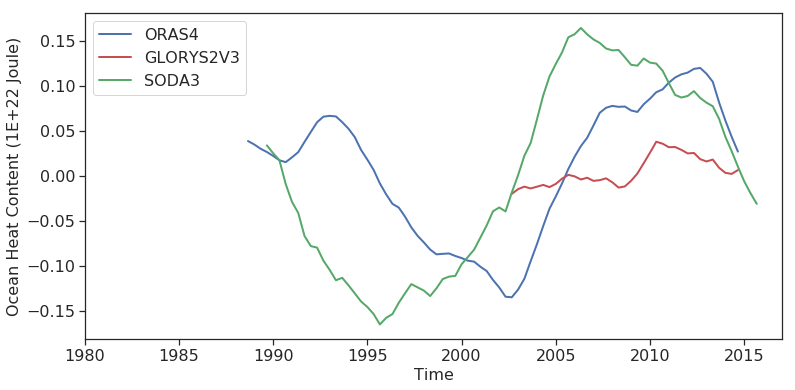

In [44]:
# comparison of OHC anomalies
index_full = np.arange(1,445,1)
index_year = np.arange(1980,2016,5)
index_full_season = np.arange(1,112,1)

fig = plt.figure()
plt.plot(index_full_season[29:-3],stat_OHC_ORAS4._lowpass,'b-',linewidth=2.0,label='ORAS4')
plt.plot(index_full_season[42+29:-3],stat_OHC_GLORYS2V3._lowpass,'r-',linewidth=2.0,label='GLORYS2V3')
plt.plot(index_full_season[3+29:],stat_OHC_SODA3._lowpass,'g-',linewidth=2.0,label='SODA3')
#plt.plot(index_full[:-36],OHC_NEMO_series_sum,color='darkorange',linestyle='-',linewidth=2.0,label='NEMO ORCA083')
fig.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
plt.xticks(np.arange(4,len(year_ORAS4)*3+3+1,15),index_year,fontsize=16)
plt.ylabel("Ocean Heat Content (1E+22 Joule)",fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=True, loc=2, prop={'size': 16})
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.show()
fig.savefig(os.path.join(output_path,'Comp_OHC_series_anomaly_DJF_60N_90N'), dpi = 400)

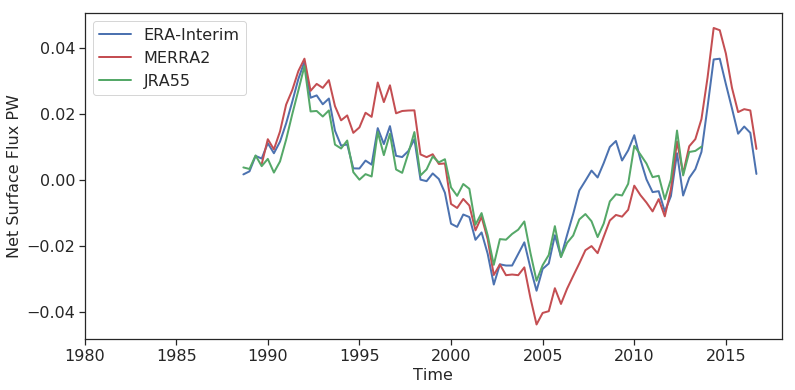

In [43]:
# comparison of SFlux anomalies
index_full = np.arange(1,457,1)
index_year = np.arange(1980,2016,5)
index_full_season = np.arange(1,115,1)

fig = plt.figure()
plt.plot(index_full_season[29:],stat_SFlux_ERAI._lowpass,'b-',linewidth=2.0,label='ERA-Interim')
plt.plot(index_full_season[3+29:],stat_SFlux_MERRA2._lowpass,'r-',linewidth=2.0,label='MERRA2')
plt.plot(index_full_season[29:-9],stat_SFlux_JRA55._lowpass,'g-',linewidth=2.0,label='JRA55')
#plt.plot(index_full[:-36],OHC_NEMO_series_sum,color='darkorange',linestyle='-',linewidth=2.0,label='NEMO ORCA083')
fig.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
plt.xticks(np.arange(4,len(year_ORAS4)*3+3+1,15),index_year,fontsize=16)
plt.ylabel("Net Surface Flux PW",fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=True, loc=2, prop={'size': 16})
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.show()
fig.savefig(os.path.join(output_path,'Comp_SFlux_series_anomaly_DJF_60N_90N'), dpi = 400)

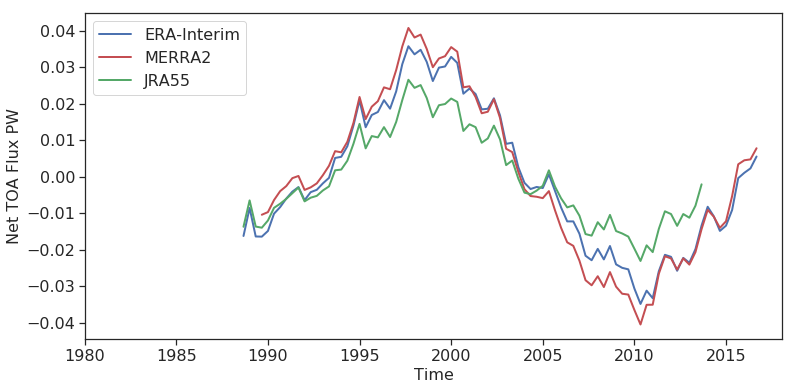

In [54]:
# comparison of SFlux anomalies
index_full = np.arange(1,457,1)
index_year = np.arange(1980,2016,5)
index_full_season = np.arange(1,115,1)

fig = plt.figure()
plt.plot(index_full_season[29:],stat_TOA_ERAI._lowpass,'b-',linewidth=2.0,label='ERA-Interim')
plt.plot(index_full_season[3+29:],stat_TOA_MERRA2._lowpass,'r-',linewidth=2.0,label='MERRA2')
plt.plot(index_full_season[29:-9],stat_TOA_JRA55._lowpass,'g-',linewidth=2.0,label='JRA55')
#plt.plot(index_full[:-36],OHC_NEMO_series_sum,color='darkorange',linestyle='-',linewidth=2.0,label='NEMO ORCA083')
fig.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
plt.xticks(np.arange(4,len(year_ORAS4)*3+3+1,15),index_year,fontsize=16)
plt.ylabel("Net TOA Flux PW",fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=True, loc=2, prop={'size': 16})
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.show()
fig.savefig(os.path.join(output_path,'Comp_TOAFlux_series_anomaly_DJF_60N_90N'), dpi = 400)

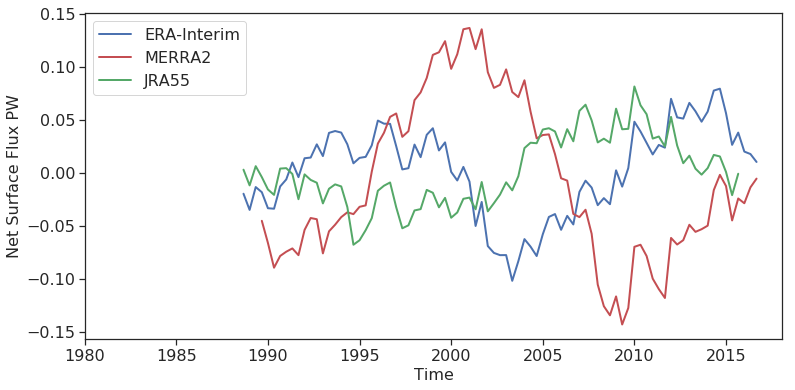

In [42]:
# comparison of SFlux anomalies
index_full = np.arange(1,457,1)
index_year = np.arange(1980,2016,5)
index_full_season = np.arange(1,115,1)

fig = plt.figure()
plt.plot(index_full_season[29:],stat_AMET_ERAI._lowpass,'b-',linewidth=2.0,label='ERA-Interim')
plt.plot(index_full_season[3+29:],stat_AMET_MERRA2._lowpass,'r-',linewidth=2.0,label='MERRA2')
plt.plot(index_full_season[29:-3],stat_AMET_JRA55._lowpass,'g-',linewidth=2.0,label='JRA55')
#plt.plot(index_full[:-36],OHC_NEMO_series_sum,color='darkorange',linestyle='-',linewidth=2.0,label='NEMO ORCA083')
fig.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
plt.xticks(np.arange(4,len(year_ORAS4)*3+3+1,15),index_year,fontsize=16)
plt.ylabel("Net Surface Flux PW",fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=True, loc=2, prop={'size': 16})
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.show()
fig.savefig(os.path.join(output_path,'Comp_AMET_series_anomaly_DJF_60N'), dpi = 400)

In [51]:
# linear regression on surface flux
#ERA-Interim
slope, _, r_value, p_value, _ = stats.linregress(stat_SFlux_ERAI._lowpass,stat_AMET_ERAI._lowpass)
print ('ERA-Interim')
print ('regression coefficient (PW/PW)')
print (slope)
print ('correlation coefficient')
print (r_value)
print ('t-test')
print (p_value)
# MERRA2
slope, _, r_value, p_value, _ = stats.linregress(stat_SFlux_MERRA2._lowpass,stat_AMET_MERRA2._lowpass)
print ('MERRA2')
print ('regression coefficient (PW/PW)')
print (slope)
print ('correlation coefficient')
print (r_value)
print ('t-test')
print (p_value)
# JRA55
slope, _, r_value, p_value, _ = stats.linregress(stat_SFlux_JRA55._lowpass,stat_AMET_JRA55._lowpass[:-6])
print ('JRA55')
print ('regression coefficient (PW/PW)')
print (slope)
print ('correlation coefficient')
print (r_value)
print ('t-test')
print (p_value)

ERA-Interim
regression coefficient (PW/PW)
1.8117098956201678
correlation coefficient
0.7140867086560921
t-test
1.6929562470576927e-14
MERRA2
regression coefficient (PW/PW)
-0.6728902894351498
correlation coefficient
-0.2053772794453729
t-test
0.06416897543875397
JRA55
regression coefficient (PW/PW)
-0.6996569933462702
correlation coefficient
-0.2771147014915908
t-test
0.015373528105595561


In [52]:
# linear regression on OHC
# ORAS4 on ERA-Interim
slope, _, r_value, p_value, _ = stats.linregress(stat_OHC_ORAS4._lowpass,stat_AMET_ERAI._lowpass[:-6])
print ('ERA-Interim')
print ('regression coefficient (PW/PW)')
print (slope)
print ('correlation coefficient')
print (r_value)
print ('t-test')
print (p_value)
# ORAS4 on MERRA2
slope, _, r_value, p_value, _ = stats.linregress(stat_OHC_ORAS4._lowpass[3:],stat_AMET_MERRA2._lowpass[:-6])
print ('MERRA2')
print ('regression coefficient (PW/PW)')
print (slope)
print ('correlation coefficient')
print (r_value)
print ('t-test')
print (p_value)
# ORAS4 on JRA55
slope, _, r_value, p_value, _ = stats.linregress(stat_OHC_ORAS4._lowpass,stat_AMET_JRA55._lowpass[:-3])
print ('JRA55')
print ('regression coefficient (PW/PW)')
print (slope)
print ('correlation coefficient')
print (r_value)
print ('t-test')
print (p_value)

ERA-Interim
regression coefficient (PW/PW)
0.2735882911301767
correlation coefficient
0.47994055287291765
t-test
7.616639685014674e-06
MERRA2
regression coefficient (PW/PW)
-0.9344487229366322
correlation coefficient
-0.9140109204313519
t-test
1.023604487116073e-30
JRA55
regression coefficient (PW/PW)
0.2501789957144603
correlation coefficient
0.5569766716284011
t-test
9.778017660411453e-08


In [55]:
# linear regression on surface flux
#ERA-Interim
slope, _, r_value, p_value, _ = stats.linregress(stat_TOA_ERAI._lowpass,stat_AMET_ERAI._lowpass)
print ('ERA-Interim')
print ('regression coefficient (PW/PW)')
print (slope)
print ('correlation coefficient')
print (r_value)
print ('t-test')
print (p_value)
# MERRA2
slope, _, r_value, p_value, _ = stats.linregress(stat_TOA_MERRA2._lowpass,stat_AMET_MERRA2._lowpass)
print ('MERRA2')
print ('regression coefficient (PW/PW)')
print (slope)
print ('correlation coefficient')
print (r_value)
print ('t-test')
print (p_value)
# JRA55
slope, _, r_value, p_value, _ = stats.linregress(stat_TOA_JRA55._lowpass,stat_AMET_JRA55._lowpass[:-6])
print ('JRA55')
print ('regression coefficient (PW/PW)')
print (slope)
print ('correlation coefficient')
print (r_value)
print ('t-test')
print (p_value)

ERA-Interim
regression coefficient (PW/PW)
-0.22084417304914628
correlation coefficient
-0.10126921431975618
t-test
0.356421301598396
MERRA2
regression coefficient (PW/PW)
2.6486074380206497
correlation coefficient
0.7708271795760512
t-test
2.4666386952487892e-17
JRA55
regression coefficient (PW/PW)
-2.082553490491333
correlation coefficient
-0.791316612312217
t-test
1.7889022619089678e-17
